In [59]:
from SimPEG import *
from SimPEG import EM
from scipy.constants import mu_0
import numpy as np
import scipy.sparse as sp
from simpegEMIP.StretchedExponential import SEInvImpulseProblem, SESurvey
import matplotlib.pyplot as plt
from pymatsolver import PardisoSolver
from simpegem1d import DigFilter
%matplotlib inline
import matplotlib 
matplotlib.rcParams["font.size"] = 14

def ColeColePelton(f, sigmaInf, eta, tau, c):
    w = 2*np.pi*f
    return sigmaInf*(1 - eta/(1 + (1-eta)*(1j*w*tau)**c))

def ColeColeSeigel(f, sigmaInf, eta, tau, c):
    w = 2*np.pi*f
    return sigmaInf*(1 - eta/(1 + (1j*w*tau)**c))
time = np.logspace(-6,np.log10(0.01), 41)
# plt.loglog(time, true, 'k', lw=1)
# plt.loglog(time, approx, 'r.')
# time = np.logspace(-3,np.log10(4), 41)
wt, tbase, omega_int = DigFilter.setFrequency(time)
frequency = omega_int / (2*np.pi)
siginf, eta0, tau0, c0 = 1., 0.8, 0.003, 0.5
sigma = ColeColeSeigel(frequency, siginf, eta0, tau0, c0)
sigTCole = DigFilter.transFiltImpulse(sigma, wt, tbase, omega_int, time, tol=1e-12)

In [60]:
wires = Maps.Wires(('eta', 1), ('tau', 1), ('c', 1))
taumap = Maps.ExpMap(nP=1)*wires.tau
survey = SESurvey()
dtrue = -sigTCole
survey.dobs = dtrue
m1D = Mesh.TensorMesh([np.ones(3)])
prob = SEInvImpulseProblem(m1D, etaMap = wires.eta, tauMap = taumap, cMap=wires.c)
prob.time = time
prob.pair(survey)
m0 = np.r_[eta0, np.log(tau0), c0]

In [61]:
perc = 0.01
dmisfitpeta = DataMisfit.l2_DataMisfit(survey)
dmisfitpeta.Wd = 1/(abs(survey.dobs)*perc)
reg = Regularization.BaseRegularization(m1D)
opt = Optimization.ProjectedGNCG(maxIter = 5)
invProb = InvProblem.BaseInvProblem(dmisfitpeta, reg, opt)
# Create an inversion object
target = Directives.TargetMisfit()
betaSch = Directives.BetaSchedule(coolingFactor=1, coolingRate=1)
# invProb.beta = 0.
inv = Inversion.BaseInversion(invProb, directiveList=[betaSch, target])
reg.mref = 0.*m0
prob.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')
opt.tolX = 1e-20
opt.tolF = 1e-20
opt.tolG = 1e-20
opt.eps = 1e-20
# opt.lower = 0.
mopt = inv.run(m0)

SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e+00  6.71e+03  1.73e+01  6.72e+03    1.49e+05      0              
   1  1.00e+00  7.45e+02  1.72e+01  7.62e+02    3.71e+03      0              
   2  1.00e+00  1.93e+02  1.95e+01  2.13e+02    6.52e+03      0   Skip BFGS  
   3  1.00e+00  1.79e+02  1.95e+01  1.99e+02    6.59e+02      0              
   4  1.00e+00  1.65e+02  1.92e+01  1.85e+02    2.45e+02      0              
   5  1.00e+00  1.65e+02  1.92e+01  1.84e+02    1.26e+00      0   Skip BFGS  
------------------------- STOP! -------------------------
0 : |fc-fOld| = 3.6541e-02 <= tolF*(1+|f0|) = 6.725

In [62]:
def ColeSEImpulse(time, eta, tau, c):    
    return eta*c/time*((time/tau)**c)*np.exp(-(time/tau)**c)
def ColeSEImpulseApprox(time, eta, tau, c):    
    m = eta*c/(tau**c)    
    peta = m*time**(c-1.) * (1. - (time/tau)**c )  
    return peta

True      eta, tau and c = 8e-01, 3e-03 and 0.5
Initial   eta, tau and c = 8e-01, 3e-03 and 0.5
Estimated eta, tau and c = 7e-01, 2e-03 and 0.5


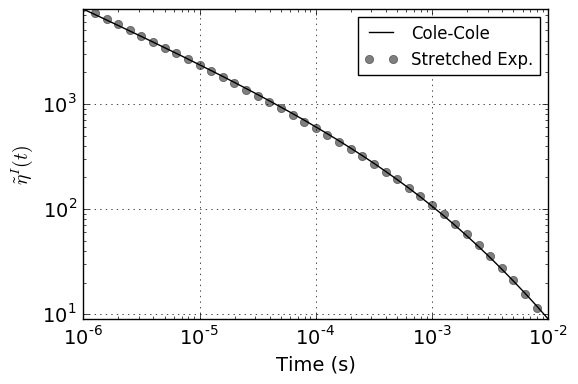

In [77]:
nskip=1
fig = plt.figure()
plt.loglog(prob.time, survey.dobs, 'k', lw=1)
plt.loglog(prob.time, invProb.dpred, 'ko', alpha = 0.5)
vmin, vmax = survey.dobs.min(), survey.dobs.max()
plt.ylim(vmin, vmax)
# legend(("pred", "obs"))
print ("True      eta, tau and c = %.e, %.e and %3.1f")%(eta0, tau0, c0)
print ("Initial   eta, tau and c = %.e, %.e and %3.1f")%(eta0, tau0, c0)
print ("Estimated eta, tau and c = %.e, %.e and %3.1f")%(mopt[0], np.exp(mopt[1]), mopt[2])

plt.xlabel("Time (s)")
plt.ylabel("$\\tilde {\eta}^I (t)$")
plt.legend(("Cole-Cole", "Stretched Exp."), fontsize = 12)
plt.grid(True)
# fig.savefig("")

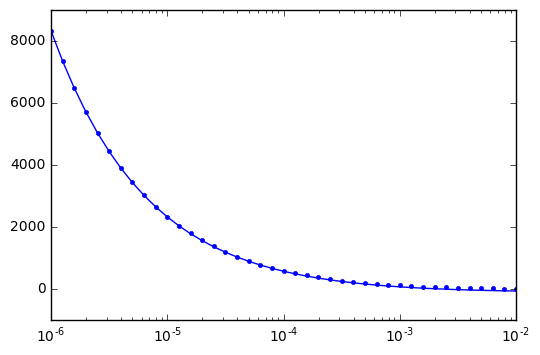

In [6]:
plt.semilogx(prob.time, ColeSEImpulseApprox(prob.time, mopt[0], np.exp(mopt[1]), mopt[2]), 'b-')
plt.semilogx(prob.time, ColeSEImpulse(prob.time, mopt[0], np.exp(mopt[1]), mopt[2]), 'b.')

In [7]:
eta, tau, c = mopt[0], np.exp(mopt[1]), mopt[2]

In [8]:
cs, ncx, ncz, npad = 5., 25, 20, 18
hx = [(cs,ncx), (cs,npad,1.3)]
hz = [(cs,npad,-1.3), (cs,ncz), (cs,npad,1.3)]
mesh = Mesh.CylMesh([hx,1,hz], '00C')    
sigmaInf = np.ones(mesh.nC) * 0.01
airind = mesh.gridCC[:,2]>0.
sigmaInf[airind] = 1e-8
etavec = np.ones(mesh.nC) * eta 
etavec[airind] = 0.
tauvec = np.ones(mesh.nC) * tau
cvec = np.ones(mesh.nC) * c
wiresEM = Maps.Wires(('sigmaInf', mesh.nC), ('eta', mesh.nC), ('tau', mesh.nC), ('c', mesh.nC))
tauvecmap = Maps.ExpMap(nP=mesh.nC) * wiresEM.tau

In [9]:
rxloc = np.array([[50.5, 0., 0.]])
srcloc = np.array([[0., 0., 0.]])

In [10]:
from simpegEMIP.TDEM import Problem3D_e, BaseTDEMIPProblem
from simpegEMIP.Base import BaseEMIPProblem

In [11]:
rx = EM.TDEM.Rx.Point_dbdt(rxloc, np.logspace(np.log10(2e-5), np.log10(0.009), 51), 'z')
src = EM.TDEM.Src.MagDipole([rx], waveform=EM.TDEM.Src.StepOffWaveform(), loc=srcloc)
survey = EM.TDEM.Survey([src])
prb_em = Problem3D_e(mesh, sigmaInfMap=wiresEM.sigmaInf, etaMap=wiresEM.eta, tauMap=tauvecmap, cMap=wiresEM.c)
prb_em.verbose = True
prb_em.timeSteps = [(1e-06, 5), (2.5e-06, 5), (5e-06, 5), (1e-05, 10), (2e-05, 10), (4e-05, 10), (8e-05, 10), (1.6e-04, 10), (3.2e-04, 20)]
# prb_em.timeSteps = [(1e-06, 5), (5e-06, 10), (1e-05, 10), (5e-05, 10), (1e-04, 10), (5e-04, 10), (1e-03, 10)]
prb_em.Solver = PardisoSolver
prb_em.pair(survey)
m = np.r_[sigmaInf, etavec, np.log(tauvec), cvec]

In [12]:
F = prb_em.fields(m)

**************************************************
Calculating fields(m)
**************************************************
Factoring...   (dt = 1.000000e-06)
Done
    Solving...   (tInd = 1)
    Done...
    Solving...   (tInd = 2)
    Done...
    Solving...   (tInd = 3)
    Done...
    Solving...   (tInd = 4)
    Done...
    Solving...   (tInd = 5)
    Done...
Factoring...   (dt = 2.500000e-06)
Done
    Solving...   (tInd = 6)
    Done...
    Solving...   (tInd = 7)
    Done...
    Solving...   (tInd = 8)
    Done...
    Solving...   (tInd = 9)
    Done...
    Solving...   (tInd = 10)
    Done...
Factoring...   (dt = 5.000000e-06)
Done
    Solving...   (tInd = 11)
    Done...
    Solving...   (tInd = 12)
    Done...
    Solving...   (tInd = 13)
    Done...
    Solving...   (tInd = 14)
    Done...
    Solving...   (tInd = 15)
    Done...
Factoring...   (dt = 1.000000e-05)
Done
    Solving...   (tInd = 16)
    Done...
    Solving...   (tInd = 17)
    Done...
    Solving...   (tInd = 18)

In [13]:
data = survey.dpred(m, f=F)

In [14]:
from EMTD.Utils import hzAnalyticDipoleT, hzAnalyticDipoleT_CC

In [15]:
Div = prb_em.timeMesh.faceDiv
hz = hzAnalyticDipoleT(rxloc[0][0], prb_em.timeMesh.gridFx, 0.01)
hzip = hzAnalyticDipoleT_CC(rxloc[0][0], prb_em.timeMesh.gridFx[1:], sigmaInf=0.01, eta=eta0, tau=tau0, c=c0, model="Seigel")
P = prb_em.timeMesh.getInterpolationMat(rx.times)
dhzdt = P*Div*hz
dhzdtip = P*Div*np.r_[0., hzip]

/Users/sgkang/Projects/pyEMTD/EMTD/Utils/TEM.py:7: RuntimeWarning: divide by zero encountered in divide
  theta = np.sqrt((sigma*mu_0)/(4*t))
/Users/sgkang/Projects/pyEMTD/EMTD/Utils/TEM.py:11: RuntimeWarning: invalid value encountered in multiply
  t2 = (1/np.sqrt(pi))*(9/tr + 4*tr)*np.exp(-tr**2)


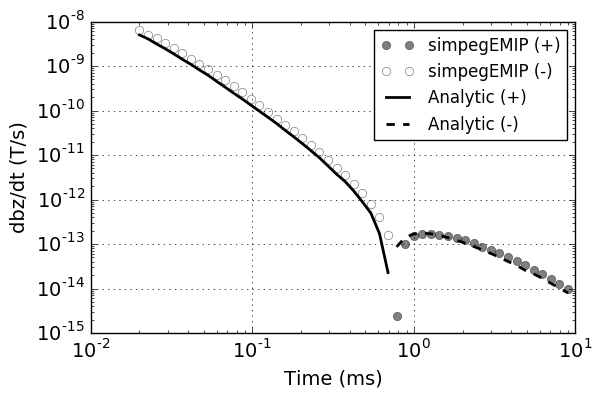

In [78]:
scale = 1.
ms = 1e3
plt.loglog(rx.times*ms, data.flatten(), 'ko', alpha = 0.5)
plt.loglog(rx.times*ms, -data.flatten(), 'o', markerfacecolor="w", alpha = 0.5)
plt.loglog(rx.times*ms, -dhzdtip.flatten()*mu_0*scale, 'k-', lw=2)
plt.loglog(rx.times*ms, dhzdtip.flatten()*mu_0*scale, 'k--', lw=2)
plt.grid(True)
plt.tight_layout()
plt.xlabel("Time (ms)")
plt.ylabel("dbz/dt (T/s)")
plt.legend(("simpegEMIP (+)", "simpegEMIP (-)", "Analytic (+)", "Analytic (-)"), fontsize = 12)